<h1>Convolutional Neural Networks</h1>
<br>
<img src="https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png" width="900" align="center">

<br><br>
In this lab we will be constructing and training a "Convolutional Neural Network" aka a neural network that contains convolution kernels with learnable parameters.<br>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [47]:
# The size of our mini batches
batch_size = 128

# How many itterations of our dataset
num_epochs = 20

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "../../datasets"

In [14]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

<h3> Create a transform for the input data </h3>
As we have seen, we often wish to perform some operations on data before we pass it through our model. Such operations could be, cropping or resizing images, affine transforms and data normalizations. Pytorch's torchvision module has a large number of such "transforms" which can be strung together sequentially using the "Compose" function. <br>

Pytorch's inbuilt datasets take a transform as an input and will apply this transform to the data before passing it to you! This makes preprocessing data really easy! We will see more about data preprocessing in a later lab!

[torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#)

In [15]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation

#The "compose" function allows us to string together transformations
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])]) #Normalize only takes it to a 
#Mean=0.1307 pixel values and std=0.308 

# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1 #Converts values between 0-1 in the image
#We should perform this operation because our values are mean centered zero and normalized
# Note: We are normalizing with the dataset mean and std 

<h3> Create the training, testing and validation data</h3>
When training many machine learning systems it is best practice to have our TOTAL dataset split into three segments, the training set, testing set and validation set. Up until now we have only had a train/test set split and have used the test set to gauge the performance during training. Though for the most "unbiased" results we should really not use our test set until training is done! So if we want to evaluate our model on an "unseen" part of the dataset we need another split - the validation set. <br><br>
<b>Training set</b>   - the data we train our model on<br>
<b>Validation set</b> - the data we use to gauge model performance during training<br>
<b>Testing set</b>   - the data we use to "rate" our trained model<br>

In [16]:
# Define our MNIST Datasets
# Can also try with CIFAR10 Dataset
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform) #This is the data we use to train the model on
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)  #We use to test our training (tune our parameters)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9 

# Determine the number of samples for each split
n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42)) #We split some data (10%) of training data and use it for validaiton

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!! => Important to input the seed manually so it is repeatable
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

<h3> Check the lengths of all the datasets</h3>

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


<h3> Create the dataloader</h3>

In [18]:
# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size) #We set up the dataloadder for training/testing/validating the model
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

<h2> Create the LeNet5 network</h2>

[LeNet5](https://en.wikipedia.org/wiki/LeNet) is a "classic" old convolution neural network (one of the oldest dating back to 1998) we will be creating an implementation of it here! It uses both convolutional layers and linear layers to "learn" features of the image and perform the classification. <br>
It also uses [Max Pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) to downsample the "feature maps" (the 2d hidden layers at the output of a convolutional layer, in the image at the top of the notebook they are called "Subsampling" layers)


In [25]:
class LeNet(nn.Module):
    def __init__(self, channels_in):
        # Call the __init__ function of the parent nn.module class
        super(LeNet, self).__init__()
        # Define Convolution Layers
        # conv1 6 channels_inx5x5 kernels
        self.conv1 = nn.Conv2d(in_channels=channels_in,out_channels=6,kernel_size=5) #Our layers are actually the cones that are shown
            #Number of channels-out gives us the number of feature maps out (essentially after doing the convolution, how many feature maps do we have?)
        
        # conv2 16 6x5x5 kernels
        self.conv2 =  nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5) 
        
        # Define MaxPooling Layers
        # Default Stride is = to kernel_size
        self.maxpool = nn.MaxPool2d(kernel_size=2) #Reasoning we do max-pooling is because magnitude of convolution tells us how strong a feature is in that kernel
        #We don't need to define multiple maxpooling layers because there is no learnable params in the maxpool


        # Define Linear/Fully connected/ Dense Layers
        # Input to linear1 is the number of features from previous conv - 16x5x5
        # output of linear1 is 120
        self.linear1 = nn.Linear(in_features=16*5*5,out_features=120)
        # output of linear2 is 84
        self.linear2 = nn.Linear(in_features=120,out_features=84)
        # output of linear3 is 10
        self.linear3 = nn.Linear(in_features=84,out_features=10)
            
    def forward(self, x):
        # Pass input through conv layers
        # x shape is BatchSize-3-32-32
        
        out1 = F.relu(self.conv1(x))# conv1 then relu
        # out1 shape is BatchSize-6-28-28
        out1 = self.maxpool(out1)# maxpool
        # out1 shape is BatchSize-6-14-14

        out2 = F.relu(self.conv2(out1))# conv2 then relu
        # out2 shape is BatchSize-16-10-10
        out2 = self.maxpool(out2)# maxpool
        # out2 shape is BatchSize-16-5-5

        # Flatten out2 to shape BatchSize-16x5x5
        out2 = out2.view(out2.shape[0],-1) # reshape to a 2D tensor, it is a 2D tensor
        
        out3 = F.relu(self.linear1(out2))# linear1 then relu
        # out3 shape is BatchSize-120
        out4 = F.relu(self.linear2(out3))# linear2 then relu
        # out4 shape is BatchSize-84
        out5 = self.linear3(out4)# linear3 then relu
        # out5 shape is BatchSize-10
        
        return out5

<h3> Create our model and view the ouput! </h3>

In [26]:
# Create a dataloader itterable object
dataiter = iter(test_loader) #This is an iteration for each set of batch sizes (16)
# Sample from the itterable object
test_images, test_labels = next(dataiter)

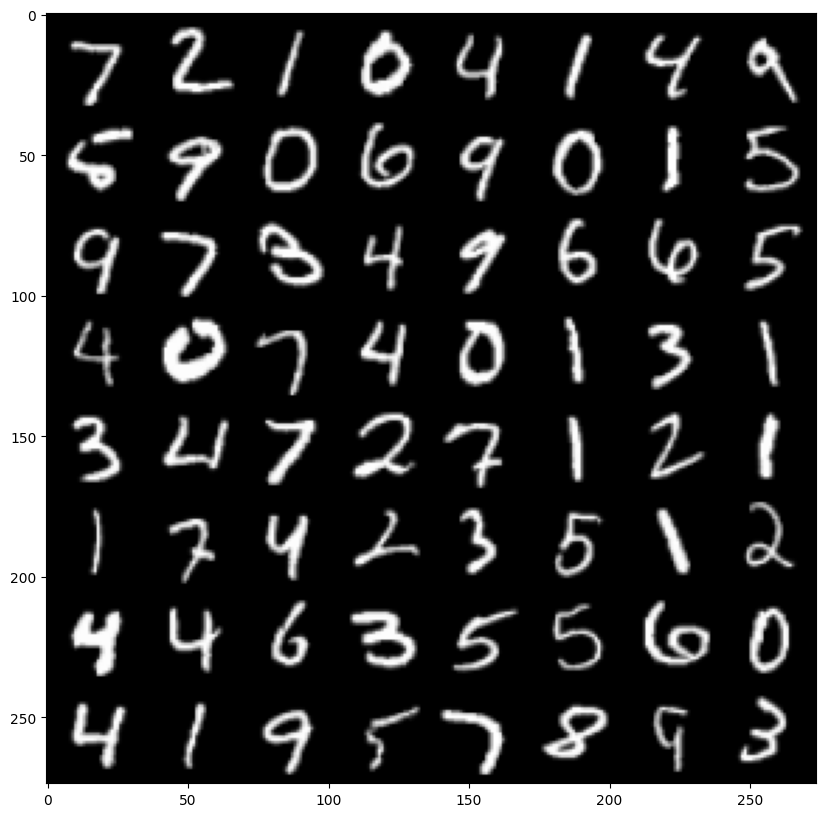

In [27]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [28]:
# Create an instance of our network and put it on our device
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = LeNet(channels_in=test_images.shape[1]).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Pass image through network
out = model(test_images.to(device))#TODO

# Check output
out.shape #The batch size was 64 (so 64 is first dim), and the output is 10 (10 classes) => the output is essentially a distribution over the ten classes

torch.Size([64, 10])

<h3> Set up the optimizer </h3>

In [30]:
# Pass our network parameters to an Adam optimiser and set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [32]:
# Define a Cross Entropy Loss
loss_fun =  nn.CrossEntropyLoss()

# Define the training process

In [35]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    
    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx =  model(x.to(device)) #TODO
        
        # Calculate loss using loss function
        loss = loss_fun(fx,y.to(device)) #TODO

        # Zero gradients
        #TODO
        optimizer.zero_grad()
        
        # Backpropagate gradients
        #TODO
        loss.backward()
        
        # Do a single optimization step
        #TODO
        optimizer.step()
        
        # Log the loss for plotting
        loss_logger.append(loss.item())
        
    # Return the avaerage loss and acc from the epoch as well as the logger array       
    return model, optimizer, loss_logger

# Define the testing process

In [36]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            #TODO
            fx=model(x.to(device))
            
            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
    # Return the accuracy from the epoch     
    return epoch_acc / len(loader.dataset)

# The training process

In [37]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [38]:
# This cell implements our training loop
for epoch in trange(num_epochs, leave=False, desc="Epoch"):
    
    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model,optimizer,train_loader,device,loss_fun,training_loss_logger)#TODO
    
    # Call the evaluate function and pass the dataloader for both ailidation and training
    train_acc = evaluate(model,device,train_loader)#TODO
    valid_acc = evaluate(model,device,valid_loader)#TODO
    
    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)
    
print("Training Complete")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Training Complete


Text(0.5, 1.0, 'LeNet Training Loss')

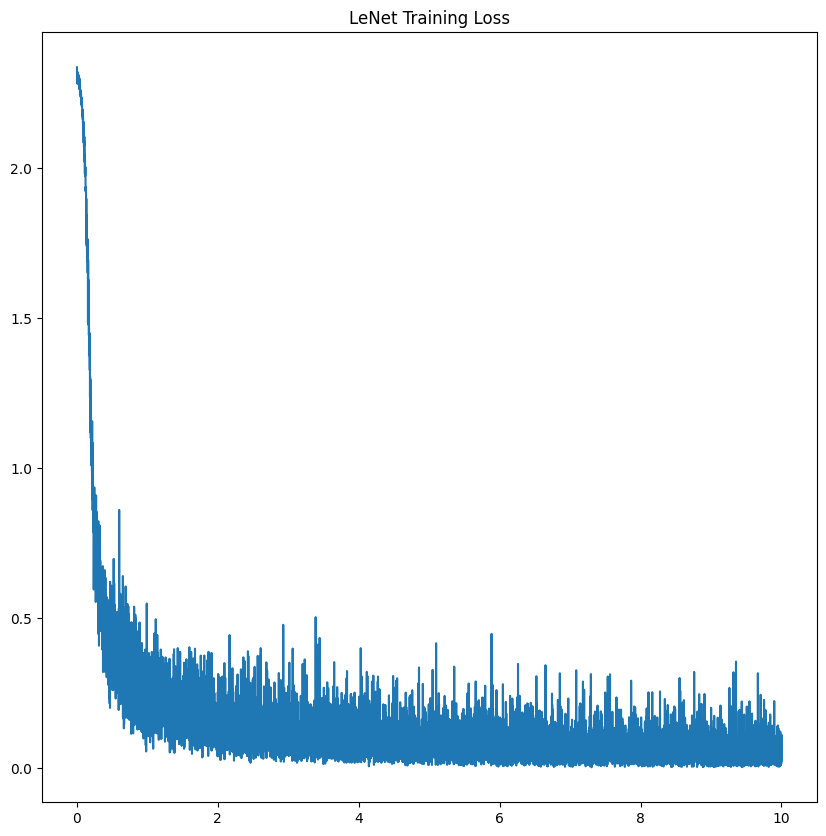

In [39]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
plt.title("LeNet Training Loss")

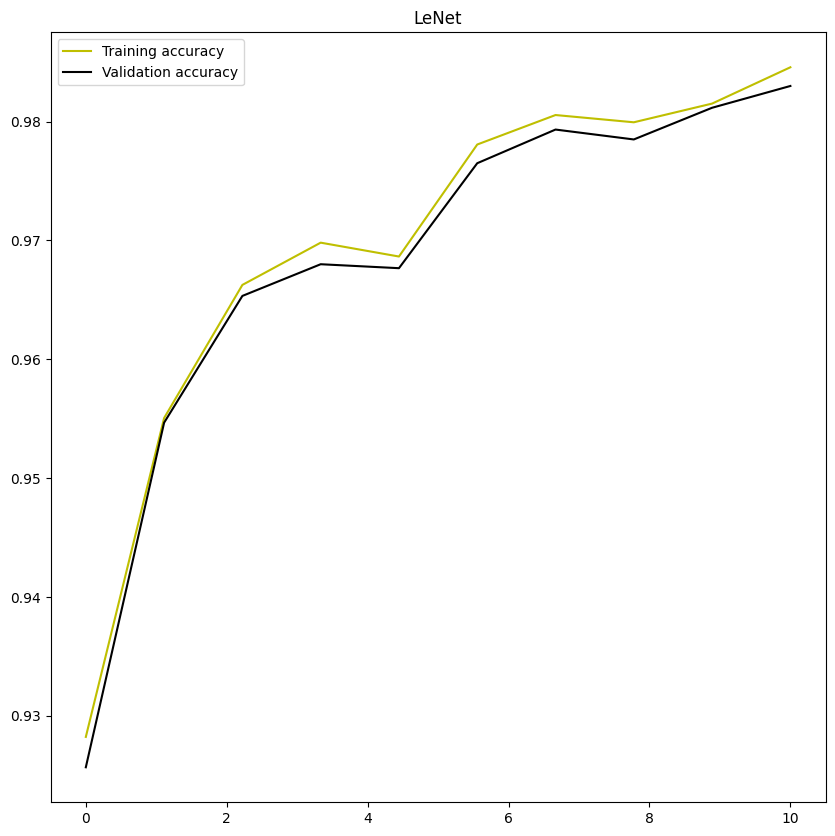

In [40]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("LeNet")
plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [41]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model,device,test_loader)#TODO
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

The total test accuracy is: 98.36%


Predicted Values
 [np.int64(7), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(9)]
True Values
 [np.int64(7), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(9)]


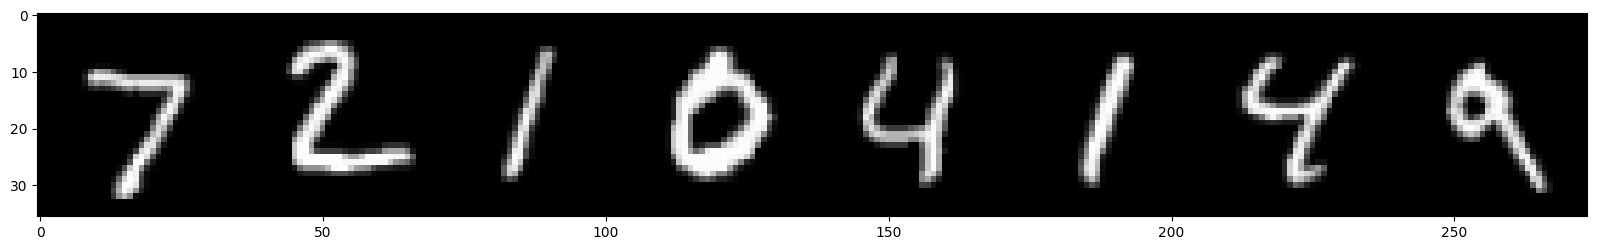

In [42]:
# Lets visualise the prediction for a few test images!

images_to_test = test_images[:8]
with torch.no_grad():
    # Forward pass of the images to test
    fx = model(images_to_test.to(device))#TODO
    
    # Get the class indices
    class_pred = fx.argmax(-1)#TODO
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images_to_test, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(class_pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))

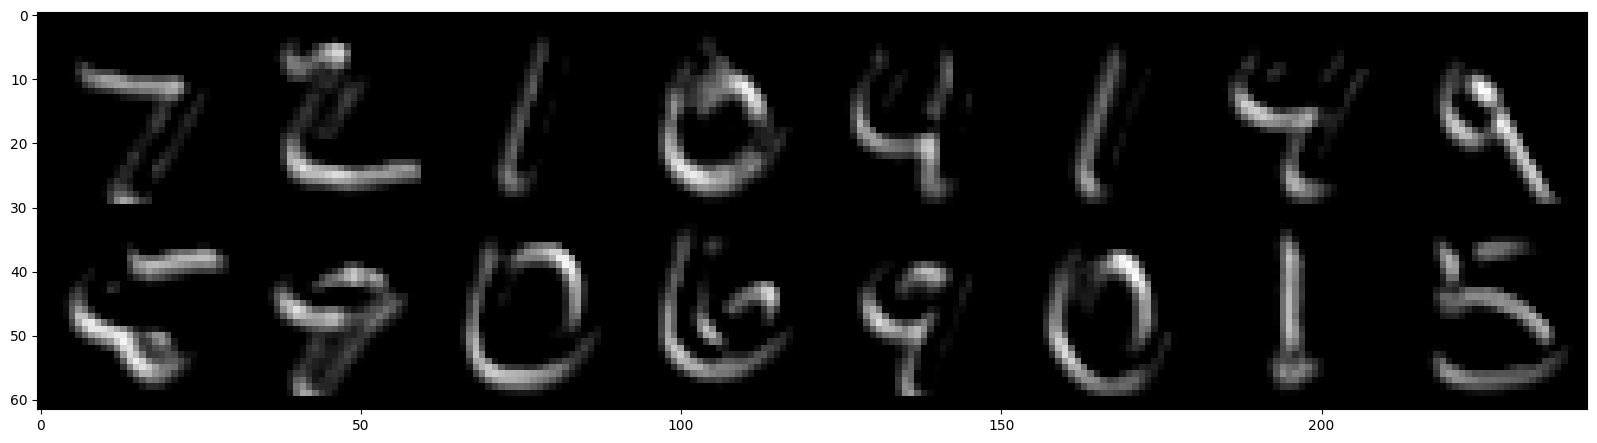

In [46]:
with torch.no_grad():
    model_out=F.relu(model.conv1(test_images.to(device)))
plt.figure(figsize=(20,10))
out=torchvision.utils.make_grid(model_out[:16,3].unsqueeze(1).detach().cpu(),8,normalize=True)
plt.imshow(out.numpy().transpose((1,2,0)))